In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from yfinance import download
from datetime import datetime, timedelta

# Get stock data from Yahoo Finance
start_date = datetime.now() - timedelta(days=365)  # Last 1 years
end_date = datetime.now()
df = download("AAPL", start_date, end_date)



[*********************100%%**********************]  1 of 1 completed


In [119]:
df = df.reset_index()

In [120]:
import time

# Delay for 10 seconds
time.sleep(5)

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [121]:
# Handle missing values (e.g., fillna with previous value or interpolate)
df.fillna(method='ffill', inplace=True)

# Feature scaling (important for RNN performance)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Function to create dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create lookback window
look_back = 20  # Adjust lookback period as needed

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)



C:\Users\Harsh\AppData\Local\Temp\ipykernel_6740\2235241789.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Epoch 1/100


C:\Users\Harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0433
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0106
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0115
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0100
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0093
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074
Epoch 16/100
6/6 ━━━━━━━━━━━━━━

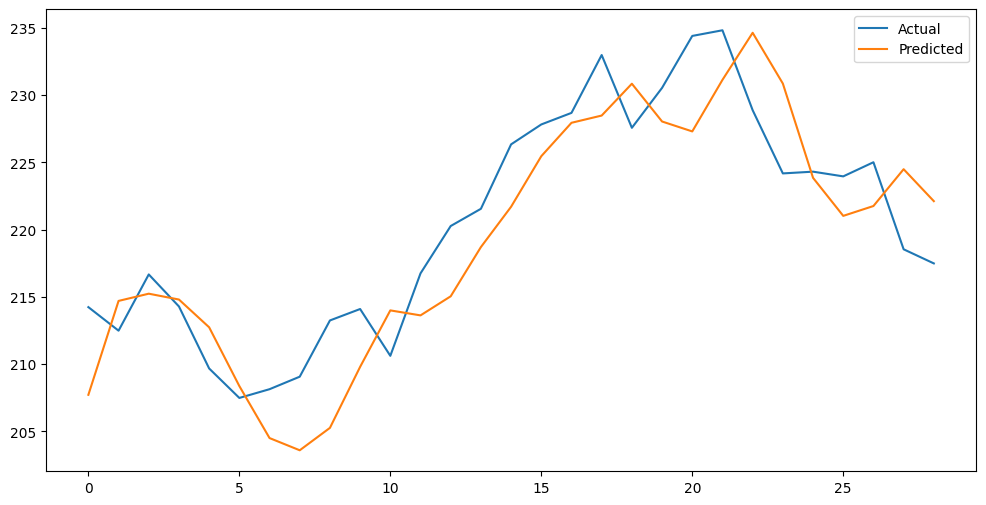

In [122]:
# Create the RNN model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

# Make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Inverse scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

# Calculate RMSE
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(trainY[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(testY[0], test_predict[:,0]))
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(testY[0], label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.show()

In [123]:
np.corrcoef(test_predict[:,0],testY)

array([[1.        , 0.88745268],
       [0.88745268, 1.        ]])

In [140]:
slope_a = actual_array[0][2]
slope_a

216.66999816894528

29

In [166]:
# Backtesting with buy and sell signals
initial_balance = 10000
stock_price = df['Close'][-len(test_predict):]
trade_log = []
current_pos = 0
qty = 0
# 0- no pos, 1- long, -1 means short

predicted_array = test_predict[:,0]
actual_array = testY
slope_predicted = np.gradient(predicted_array)
# slope_actual = np.gradient(actual_array)

for i in range(3, len(predicted_array)):
    slope_p = slope_predicted[i]
    slope_a = actual_array[0][i-1] - actual_array[0][i-2]

    if(slope_p>0 and slope_a>0):
        # buy the scrip
        if(current_pos == 0): # if no position currently - take a long
            qty = initial_balance/actual_array[0][i]
            current_pos = 1
            initial_balance = initial_balance - (actual_array[0][i]* qty)
            trade_log.append("BUY AT "+str(actual_array[0][i]))

        if(current_pos == -1): # If current is short- cover the short and tak a long
            current_pos = 0
            initial_balance = initial_balance - (actual_array[0][i]* qty)
            qty = 0
            trade_log.append("EXIT AT "+str(actual_array[0][i]))

            qty = initial_balance/actual_array[0][i]
            current_pos = 1
            initial_balance = initial_balance - (actual_array[0][i]* qty)
            trade_log.append("BUY AT "+str(actual_array[0][i]))



    if(slope_p<0 and slope_a<0):
        # sell the scrip
        if(current_pos == 0): # if no position currently - take a short
            qty = initial_balance/actual_array[0][i]
            current_pos = -1
            initial_balance = initial_balance + (actual_array[0][i]* qty)
            trade_log.append("SELL AT "+str(actual_array[0][i]))

        if(current_pos == 1): # If current is long- cover the long and tak a short
            current_pos = 0
            initial_balance = initial_balance + (actual_array[0][i]* qty)
            qty = 0
            trade_log.append("EXIT AT "+str(actual_array[0][i]))

            qty = initial_balance/actual_array[0][i]
            current_pos =-1
            initial_balance = initial_balance + (actual_array[0][i]* qty)
            trade_log.append("SELL AT "+str(actual_array[0][i]))


# at last exit all positions

if(current_pos == 1): # If current is long- cover the long and tak a short
    current_pos = 0
    initial_balance = initial_balance + (actual_array[0][i]* qty)
    qty = 0
    trade_log.append("EXIT AT "+str(actual_array[0][i]))

if(current_pos == -1): # If current is short- cover the short and tak a long
    current_pos = 0
    initial_balance = initial_balance - (actual_array[0][i]* qty)
    qty = 0
    trade_log.append("EXIT AT "+str(actual_array[0][i]))



# THIS RETURN IS MADE OVER 29 DAYS
print(initial_balance)
print(qty)
print(trade_log)


10610.152509585421
0
['SELL AT 209.67999267578125', 'EXIT AT 209.07000732421875', 'BUY AT 209.07000732421875', 'EXIT AT 230.5399932861328', 'SELL AT 230.5399932861328', 'EXIT AT 234.39999389648438', 'BUY AT 234.39999389648438', 'EXIT AT 224.17999267578122', 'SELL AT 224.17999267578122', 'EXIT AT 218.5399932861328', 'BUY AT 218.5399932861328', 'EXIT AT 217.49000549316406', 'SELL AT 217.49000549316406', 'EXIT AT 217.49000549316406']
